In [1]:
from IPython import display
import pandas as pd

from utils import decision_tree as dt
from utils import definitions as defs

## ETL

In [2]:
df = pd.read_excel(defs.ETLED_DATA_PATH_step_2)

Y = df[defs.LABEL]
X = df.drop(defs.LABEL, axis=1)

In [3]:
categorical_feature_names = [
    defs.QUESTION_3,
    'pre4. Есть ответ на вопрос 4?',
    defs.QUESTION_5,
    defs.QUESTION_6,
    defs.QUESTION_7,
    defs.QUESTION_8,
    defs.QUESTION_9,
    'pre11. Есть ответ на вопрос 11?',
    defs.QUESTION_11,
    defs.QUESTION_12,
    defs.QUESTION_13,
    defs.QUESTION_14,
    defs.QUESTION_15,
    defs.QUESTION_16,
    defs.QUESTION_17,
    defs.QUESTION_18,
    defs.QUESTION_19,
    'pre20. Есть ответ на вопрос 20?',
    defs.QUESTION_20,
    defs.QUESTION_23,
    defs.QUESTION_25,
    defs.QUESTION_26,
    defs.QUESTION_27,
    defs.QUESTION_28,
    defs.QUESTION_29,
    defs.QUESTION_30,
    defs.QUESTION_31,
    defs.QUESTION_32,
    defs.QUESTION_33,
    defs.QUESTION_34,
    defs.QUESTION_35,
]

numerical_feature_names = [
    defs.QUESTION_2,
    defs.QUESTION_4,
    defs.QUESTION_22,
    defs.QUESTION_24,
]

special_cases = {
    'pre4. Есть ответ на вопрос 4?': defs.QUESTION_4,
    defs.QUESTION_6: defs.QUESTION_7,
    defs.QUESTION_8: defs.QUESTION_9,
    'pre11. Есть ответ на вопрос 11?': defs.QUESTION_11,
    'pre20. Есть ответ на вопрос 20?': defs.QUESTION_20,
    defs.QUESTION_23: defs.QUESTION_24,
    defs.QUESTION_27: defs.QUESTION_26,
}

## Модель дерева решений

In [4]:
tree = dt.DecisionTree()

In [5]:
tree.fit(X, Y, categorical_feature_names, numerical_feature_names, special_cases=special_cases)

Входное множество содержит NaN
Признак - 20. Каков уровень образования Вашего партнера (если применимо)?
Входное множество содержит NaN
Признак - 20. Каков уровень образования Вашего партнера (если применимо)?
Входное множество содержит NaN
Признак - 9. Если да, сколько?
Входное множество содержит NaN
Признак - 20. Каков уровень образования Вашего партнера (если применимо)?
Входное множество содержит NaN
Признак - 7. Если да, как часто вы общаетесь?


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.91179 to fit


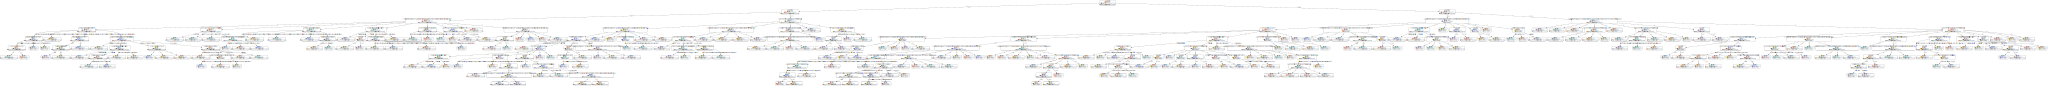

In [6]:
tree.render(rounded=True, show_num_samples=True, show_distribution=True, show_label=True, format='png')

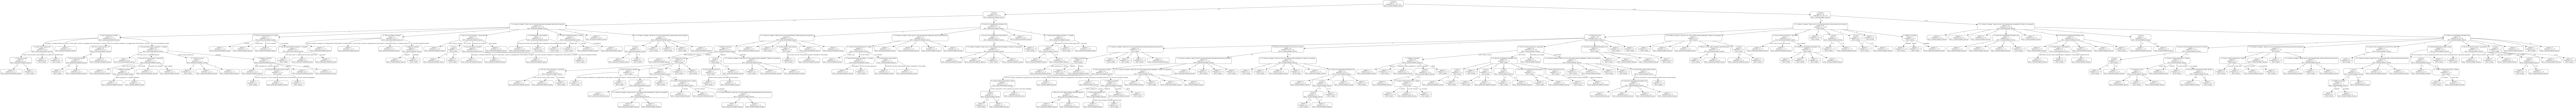

In [7]:
display.Image('дерево решений.gv.png')